# Майнор "Интеллектуальный анализ данных"

# Курс "Прикладные задачи анализа данных"

## Лабораторная работа №2. RecSys

В рамках данной лабораторной работы вам предлагается решить задачу рекомендательной системы на основе следующих данных:

* **rating.csv** - рейтинги аниме по 10 бальной шкале
* **anime.csv** - описание items

Скачать данные можно [здесь](https://drive.google.com/drive/u/1/folders/1FarHUuqQq4tQSlERB9K8uEfZAZT9tQWv)

In [ ]:
%%capture
!apt update -y && apt upgrade -y

In [ ]:
%%capture
!pip install -U pip
!pip install -q -U --no-deps matplotlib==3.5.2
!pip install -U -q lightfm
!pip install -U -q umap-learn
!pip install -U -q datashader
!pip install -U -q bokeh
!pip install -U -q holoviews
!pip install -U -q colorcet 
!pip install -U -q surprise
!pip install -U -q pandas

In [ ]:
import matplotlib
matplotlib.__version__

'3.2.2'

In [ ]:
import sklearn
sklearn.__version__

'1.0.2'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

In [ ]:
sns.set_theme(style='whitegrid')

# Данные


Данные содержат информацию об предподчтениях 73,516 пользователей в 12,294 аниме. Каждый пользователь может добавить аниме и выставить рейтниг.

Anime.csv

* anime_id - идентификатор аниме (items)
* name - полное название аниме
* genre - категория/категории для аниме (разделены запятой).
* type - тип: movie, TV, OVA, etc.
* episodes - количество эпизодов (для экранизаций)
* rating - средний рейтинг по аниме.
* members - количество членов коммьюнити к аниме

Rating.csv

* user_id - идентификатор пользователя (users)
* anime_id - идентификатор аниме
* rating - рейтинг пользователя по аниме (-1 пользователь смотрел, но не оставил рейтинг).

### ``` Если вычеслительные ресурсы не позволяют решить задачу на всех данных, то необходимо это сделать на "сэмпле" данных (выбрав от 5% ids' для user и item). Этот же подход справедлив и для оценки работы алгоритомв```

# Необходимо сделать:

## Задание №1 : Exploratory analysis (2 балла):

* Распределение числа пользователей по количеству взаимодействий
* Разпределение числа "айтемов" по количеству взаимодействий
* Распределение числа рейтингов, средних рейтингов по пользователям, по "айтемам"
* и т.д. (бонус)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
anime = pd.read_csv('/content/drive/My Drive/IAD/anime.csv')
rating = pd.read_csv('/content/drive/My Drive/IAD/rating.csv')

In [ ]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [ ]:
display(rating.head())
print(rating.shape)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


(7813737, 3)


In [ ]:
glued = rating.merge(anime, on='anime_id', how = 'left')
glued.rename(columns={'rating_x':'user_rating', 'rating_y': 'anime_rating'}, inplace= True)
print(glued.shape)
glued

(7813737, 9)


,user_id,anime_id,user_rating,name,genre,type,episodes,anime_rating,members
0,1,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0
1,1,24,-1,School Rumble,"Comedy, Romance, School, Shounen",TV,26,8.06,178553.0
2,1,79,-1,Shuffle!,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...",TV,24,7.31,158772.0
3,1,226,-1,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13,7.85,623511.0
4,1,241,-1,Girls Bravo: First Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School",TV,11,6.69,84395.0
...,...,...,...,...,...,...,...,...,...
7813732,73515,16512,7,Devil Survivor 2 The Animation,"Action, Demons, Supernatural",TV,13,7.06,101266.0
7813733,73515,17187,9,Ghost in the Shell: Arise - Border:1 Ghost Pain,"Mecha, Police, Psychological, Sci-Fi",Movie,1,7.64,31747.0
7813734,73515,22145,10,Kuroshitsuji: Book of Circus,"Comedy, Demons, Fantasy, Historical, Shounen, ...",TV,10,8.37,122895.0
7813735,73516,790,9,Ergo Proxy,"Mystery, Psychological, Sci-Fi",TV,23,8.03,265005.0


In [ ]:
glued.user_rating.value_counts().sort_index()

-1     1476496
 1       16649
 2       23150
 3       41453
 4      104291
 5      282806
 6      637775
 7     1375287
 8     1646019
 9     1254096
 10     955715
Name: user_rating, dtype: int64

Пока отбросим все наблюдения, где пользователь посмотрел тайтл, однако не поставил оценку.

In [ ]:
glued_1 = glued[glued.user_rating != -1]
glued_1.user_rating.value_counts().sort_index()

1       16649
2       23150
3       41453
4      104291
5      282806
6      637775
7     1375287
8     1646019
9     1254096
10     955715
Name: user_rating, dtype: int64

In [ ]:
glued_1.anime_rating.value_counts().sort_index()

2.00      210
2.14       76
2.37     1024
2.49        1
2.55        1
        ...  
9.16     3115
9.17    17151
9.25     1188
9.26    21494
9.37     1961
Name: anime_rating, Length: 574, dtype: int64

* Распределение числа пользователей по количеству взаимодействий

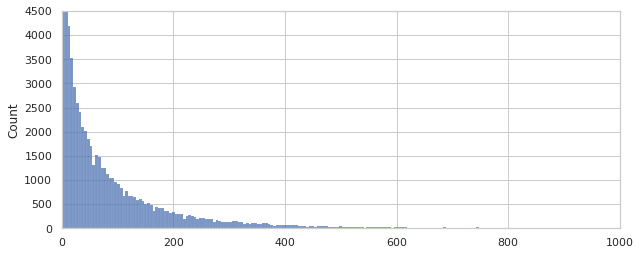

In [ ]:
fig, ax = plt.subplots(figsize = (10, 4))
sns.histplot(glued_1.user_id.value_counts().values, ax=ax)
ax.set_ylim(0, 4500)
ax.set_xlim(0, 1000)
plt.show()


Распределение скошенное, большинство пользователей оценило очень малое количестов тайтлов

* Разпределение числа "айтемов" по количеству взаимодействий

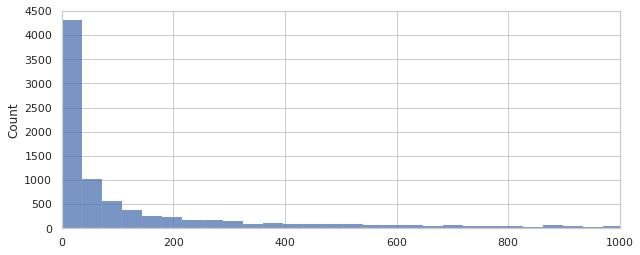

In [ ]:
fig, ax = plt.subplots(figsize = (10, 4))
sns.histplot(glued_1.anime_id.value_counts().values, ax=ax)
ax.set_ylim(0, 4500)
ax.set_xlim(0, 1000)
plt.show()

Распределение тайтлов похоже на распределение юзеров. Большая часть тайтлов была оценена несколько раз. Лишь некоторые тайтлы имеют большое количество оценок

* Распределение числа рейтингов, средних рейтингов по пользователям, по "айтемам"

**Распределение числа рейтингов**

2.0       1311
3.0        519
4.0       4277
5.0      22663
6.0     270413
7.0    2083302
8.0    3382337
9.0     572412
NaN          7
Name: anime_rating, dtype: int64

<AxesSubplot:xlabel='anime_rating', ylabel='Count'>

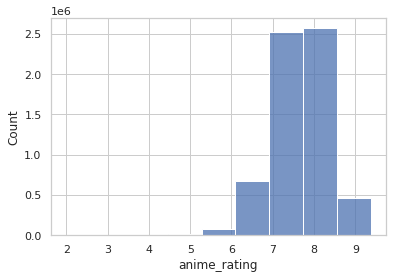

In [ ]:
# Округлим рейтинги до целого числа
display(glued_1.anime_rating.round(0).value_counts(dropna=False).sort_index())
sns.histplot(data = glued_1, x = 'anime_rating', bins=9)

Самая популярная оценка 8, 10 и 1 в выборке нет. Вторая по частоте оценка - 7. Остальные оценки пользователи ставили довольно редко.

**Средняя оценка по пользователям**

1.0        28
2.0        19
3.0        16
4.0        40
5.0       215
6.0      1513
7.0     11178
8.0     31591
9.0     18420
10.0     6580
Name: user_rating, dtype: int64

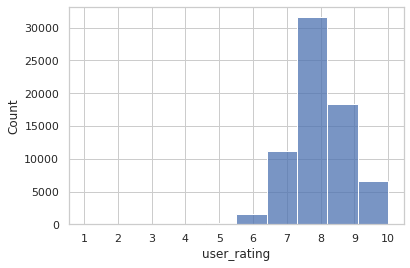

In [ ]:
usr_avg = glued_1.groupby('user_id', as_index=False).agg({'user_rating':'mean'})
display(usr_avg.user_rating.round(0).value_counts().sort_index())
fig, ax = plt.subplots()
sns.histplot(data=usr_avg.round(0), x='user_rating', bins=10, ax=ax)
ax.set_xticks([i for i in range(1, 11)])
fig.show()

Большинство пользователей оценили в среденем просмотренные тайтлы на 8, на 40 п.п. меньше пользователей в среднем оценивали просмотренные тайтлы на 9. Еще меньшее число пользователей оценило тайтлы в среднем на 6. 

**Средний рейтинг по тайтлам**

1.0       36
2.0       94
3.0      214
4.0      404
5.0      703
6.0     2132
7.0     3900
8.0     2218
9.0      189
10.0      37
Name: user_rating, dtype: int64

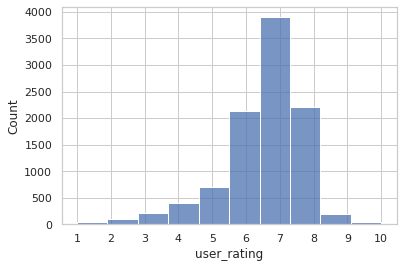

In [ ]:
uwu_avg = glued_1.groupby('anime_id', as_index=False).agg({'user_rating':'mean'})
display(uwu_avg.round(0).user_rating.value_counts().sort_index())

fig, ax = plt.subplots()
sns.histplot(data=uwu_avg.round(0), x='user_rating', bins=10, ax=ax)
ax.set_xticks([i for i in range(1, 11)])
fig.show()

Средняя оценка тайтлов по пользователям — 7, оценки 8 и 7 встречаются примерно в 2 раза реже. Менее всего оценок 1 и 10

**Распределение количества аниме по жанрам**

In [ ]:
# glued_1 = pd.concat([glued_1, glued_1['genre'].str.get_dummies(sep=', ')], axis=1)
# glued_1 = pd.concat([glued_1, glued_1['type'].str.get_dummies()], axis=1)

In [ ]:
genres = anime['genre'].str.split(', ').explode().value_counts().to_frame()
genres

,genre
Comedy,4645
Action,2845
Adventure,2348
Fantasy,2309
Sci-Fi,2070
Drama,2016
Shounen,1712
Kids,1609
Romance,1464
School,1220


**Количество средних просмотренных тайтлов у пользователя**

In [ ]:
glued.groupby('user_id').agg({'user_rating':'count'}).mean().round(0)

user_rating    106.0
dtype: float64

Каждый пользователь в среднем посмотрел 106 тайтлов

**Количество средних оценок пользователя**

In [ ]:
glued[glued.user_rating != -1].groupby('user_id').agg({'user_rating':'count'}).mean().round()

user_rating    91.0
dtype: float64

Но оценил только 91

**Самые часто просматриваемые аниме**

In [ ]:
glued.head(3)

,user_id,anime_id,user_rating,name,genre,type,episodes,anime_rating,members
0,1,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0
1,1,24,-1,School Rumble,"Comedy, Romance, School, Shounen",TV,26,8.06,178553.0
2,1,79,-1,Shuffle!,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...",TV,24,7.31,158772.0


In [ ]:
glued.groupby('name').agg({'anime_id':'count'}).sort_values('anime_id', ascending=False).head(10)

,anime_id
name,
Death Note,39340
Sword Art Online,30583
Shingeki no Kyojin,29584
Code Geass: Hangyaku no Lelouch,27718
Elfen Lied,27506
Angel Beats!,27183
Naruto,25925
Fullmetal Alchemist,25032
Fullmetal Alchemist: Brotherhood,24574


## Задание №2 : Оценить разреженность данных по рейтингу (1/2 балла)

При конструировании матрицы взаимодействий заменяется рейтинг с категориальных значений на бинарные. В нашем случае - замена рейтинга ниже 5 на "-1", так как рейтинг 5 и ниже скорее означает, что пользователю тайтл не понравился.

In [ ]:
from lightfm.data import Dataset

In [ ]:
item_feats = anime['genre'].str.get_dummies(sep=', ').rename(columns={'Music':'Music_Genre'})
types = anime['type'].str.get_dummies().rename(columns={'Music':'Music_Type'})
item_feats = pd.concat([anime[['anime_id','episodes', 'rating',
                           'members']], item_feats, types], axis = 1)
item_feats.head()

,anime_id,episodes,rating,members,Action,Adventure,Cars,Comedy,Dementia,Demons,...,Thriller,Vampire,Yaoi,Yuri,Movie,Music_Type,ONA,OVA,Special,TV
0,32281,1,9.37,200630,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,5114,64,9.26,793665,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,28977,51,9.25,114262,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,9253,24,9.17,673572,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,9969,51,9.16,151266,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
r1 = rating.sample(frac = .05)
r1 = r1.dropna()
r1 = r1[r1.rating != -1]


partial_merge = r1.merge(item_feats, on = 'anime_id', how='left', validate='m:1').rename(columns={
    'rating_x':'user_rating',
    'rating_y':'anime_rating'
})
partial_merge = partial_merge.dropna()
partial_merge['anime_rating'] = partial_merge['anime_rating'].astype(int)
partial_merge['episodes'] = partial_merge['episodes'].astype(int)

partial_merge = partial_merge.dropna(axis=0)
dataset = Dataset()
dataset.fit(users=partial_merge.user_id, 
            items=partial_merge.anime_id,
            item_features=partial_merge.iloc[:, 2:])

for col in partial_merge.columns[2:]:
  dataset.fit_partial(items=partial_merge.anime_id,
                     item_features=partial_merge[col])


interactions, weights = dataset.build_interactions(
    (row.user_id, row.anime_id) for row\
     in partial_merge[['user_id', 'anime_id']].itertuples()
)


item_features = dataset.build_item_features(
    (row.anime_id, row[2:]) for row in partial_merge.iloc[:, 1:].itertuples())

item_features

<6969x10990 sparse matrix of type '<class 'numpy.float32'>'
	with 63980 stored elements in Compressed Sparse Row format>

In [ ]:
1 - (interactions.count_nonzero() / (interactions.shape[0] * interactions.shape[1]))

0.9991100155727038

Данные разрежены на 99%

## Задание №3 : Разделить данные на тренировочные и валидационные (1/2 балла)

Сперва разделим данные для обучения и валидации для lightFM

In [ ]:
from lightfm.cross_validation import random_train_test_split

In [ ]:
train, test = random_train_test_split(interactions, test_percentage=0.2, random_state=np.random.RandomState(3))
train_weights, test_weights = random_train_test_split(weights, test_percentage=0.2, random_state=np.random.RandomState(3))
train_features, test_features = random_train_test_split(item_features, test_percentage=0.2, random_state=np.random.RandomState(3))

NameError: ignored

In [ ]:
train.shape, train_weights.shape

Далее разделим данные на тренировачные и валидационные для факторизационных алгоритмов


In [ ]:
rating[rating.rating != -1].shape

In [ ]:
from surprise.model_selection import train_test_split as surprise_split
from surprise import Reader
from surprise import Dataset
r2 = rating.sample(frac=0.05)
r2 = r2[r2 != -1]
r2 = r2.dropna()

reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(r2[['user_id', 'anime_id', 'rating']], reader)
trainset, testset = surprise_split(data, test_size=0.25)

In [ ]:
np.random.seed(42)
rng = np.random.default_rng(seed = 42)

## Задание №4 : Решить задачу на основе предложения всем юзерам наиболее популярных item (1 балл)

Предположим, что наш сайт с ~симпатичными аниме девочками по бокам uwu~ только запускается, поэтому никаких пользовательских предпочтений и взаимодействий нет. Однако, потенциально мы могли попарсиь популярные аниме сайты и собрать статистику по самым популярным тайтлам.  
В качестве меры популярности воспользуемся переменной **members**.
  
Предложим пользователям 10 случайных самых популярных тайтлов. Распределение тайтлов по пользователям - случайное. Генератор случайных чисел — стандартный генератор случайных чисел NumPy c зафикисированным сидом = 42.  


In [ ]:
def random_assigner(array: 'iterable', shape, rnd = 10, rng=rng):
  '''Random extension of the elements in a given array
  Has a core design drawback: can and probably will assign same animes
  to one user due to full random sampling and extension techniques.
  However, we may ignore this because recommender systems are usually
  allowed to recommend already seen movie or recommend one once again.
  Parametres
  ----------
  array : iterable sequence
  shape : desired shape of extended array
  rnd : number of random extensions
  rng : numpy random number generator
  Returns
  -------
  Randomly extended array of shape == shape
  '''
  arr = [[i] for i in array]
  arr1 = []

  arr_range = len(arr)
  while len(arr1) < shape:
    i = rng.choice(arr_range)
    rand = rng.integers(1, rnd+1)
    val = np.array(arr[i] * rnd).flatten()
    arr1.append(val)
  arr1 = np.concatenate(arr1)
  if len(arr1) > shape:
    arr1 = arr1[:shape]
  arr1 = rng.permutation(arr1)
  return arr1

In [ ]:
sorted_data = glued.drop_duplicates('anime_id').sort_values('members', ascending=False)['anime_id']
top_10 = sorted_data.iloc[:10]
top_100 = sorted_data.iloc[:100]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
t, rr = train_test_split(rating, train_size = 0.7, random_state=42)
rr = rating.sample(frac=0.3)
rr['assigned_anime'] = random_assigner(top_10, rr.shape[0])

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import (
      precision_score as ps, recall_score as rs)

In [ ]:
def simple_pr_rec(data) -> tuple:
  
  """
  Simple quality estimator of RandomAssigner model built on
  scikit-learn metrics.

  Estimates a number of overlapping predictions and counts 
  precision and recall. Since we predict whether user might watch an anime
  this estimator will not be used for collaborative recommedation system
  but will be used for content based recommendations.
  Estimator is inconsistent with the industry approved methods such as MRR, PR@k,
  RE@k and etc.

  Parameters
  ----------
  data : DataFrame with assigned values
  MUST contain columns as ['user_id', 'anime_id', 'rating', 'assigned_anime']
  k : value indicates position to estimate a metrics score
  Returns
  -------
  Sometimes, I don't know why, it doesn't even matter how hard you try...
  """
  
  from sklearn.metrics import (
      precision_score as ps, recall_score as rs)
  
  precision = []
  recall = []
  users = data['user_id'].unique()
  users.flags.writeable = False
  
  d = data.copy()
  d.loc[d.rating != -1, 'rating'] = 1
  d.loc[d.rating == -1, 'rating'] = 0

  for user in tqdm(users):
    use = d[d['user_id'] == user]

    real_ids = use.anime_id.values
    real_ids.flags.writeable = False

    assigned_ids = use.assigned_anime.values
    assigned_ids.flags.writeable = False

    ratings = use.rating.sort_values().values
    ratings.flags.writeable = False

    # overlaps = [1 if val in real_ids else 0 for val in assigned_ids]

    overlaps = []
    for val in assigned_ids:
      if val in real_ids:
        overlaps.append(1)
      else:
        overlaps.append(0)

    overlaps = sorted(overlaps)

    precision.append(ps(ratings, overlaps))
    recall.append(rs(ratings, overlaps))
  return np.mean(precision), np.mean(recall)


In [ ]:
%%time
simple_pr_rec(rr) # топ 10

  0%|          | 0/69733 [00:00<?, ?it/s]

CPU times: user 10min 46s, sys: 15.3 s, total: 11min 1s
Wall time: 8min 53s


(0.4905239047011912, 0.142859121925801)

На огромных объемах данных средняя точность случайных предложений относительно высока - 0.49. Полнота низкая, однако это объяснимо чистой случайностью всех предсказаний и низкою любовью большинства юзеров к популярным тайтлам.

In [ ]:
rr.drop('assigned_anime', axis=1, inplace=True)
rr['assigned_anime'] = random_assigner(top_100, rr.shape[0])

In [ ]:
%%time
simple_pr_rec(rr) # 100 самых популярных

  0%|          | 0/69733 [00:00<?, ?it/s]

CPU times: user 11min 4s, sys: 14.5 s, total: 11min 19s
Wall time: 8min 54s


(0.5053053491686719, 0.09163274774380319)

Предложение из 100 самых популярных тайтлов увеличило среднюю точностью, но снизило полноту на 64% (5 п.п.)

## Задание №5 : Решить задачу на основе коллоборативной фильтрации (2 балла)

* Реализовать один из методов коллоборативной фильтрации SVD, SVD++, ALS, ALS with implicit feedback

Сперва зададим функцию оценки результатов модели. [Взято здесь](https://surprise.readthedocs.io/en/stable/FAQ.html#precision-recall-at-k-py)

In [ ]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=5.5):
    """Estimation of precision and recall at k metrics for each user

    Parameters
    ----------
    predictions : vector of predicted values
    k : k parameter
    threshold : pos/neg rating threshold

    Returns
    -------

    """
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls


Решение задачи коллаборативной фильтрации будет представлено с помощью библиотеки Surprise.
  
Почему не с нуля: Surprise хорошо протестированная библиотека с хорошей кодовой базой, решение с нуля необходимо будет сравнивать с уже имплементированными решениями.

In [ ]:
from surprise import SVD, SlopeOne

In [ ]:
svd = SVD().fit(trainset)
preds=svd.test(testset)

k=5
precision, recall = precision_recall_at_k(preds, k=k=, threshold=5)
print(f'Mean Average Precision at {k}: {np.mean(list(precision.values())).round(2)}')
print(f'Mean Average Recall at {k}: {np.mean(list(recall.values())).round(2)}')

Mean Average Precision at 5: 0.98
Mean Average Recall at 5: 0.96


Прогоним на кросс валидации:

In [ ]:
from surprise.model_selection import KFold
kf = KFold(n_splits=5)
idx = 1
for trainset, testset in kf.split(data):
  svd = SVD()
  svd.fit(trainset)
  predictions = svd.test(testset)
  precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=5)

  # Precision and recall can then be averaged over all users
  print(f'Fold {idx}')
  print(f'Mean Average Precision at {k}: {np.mean(list(precision.values())).round(2)}')
  print(f'Mean Average Recall at {k}: {np.mean(list(recall.values())).round(2)}')
  idx = idx + 1                                              

Fold 1
Mean Average Precision at 5: 0.98
Mean Average Recall at 5: 0.96
Fold 2
Mean Average Precision at 5: 0.98
Mean Average Recall at 5: 0.96
Fold 3
Mean Average Precision at 5: 0.98
Mean Average Recall at 5: 0.96
Fold 4
Mean Average Precision at 5: 0.98
Mean Average Recall at 5: 0.96
Fold 5
Mean Average Precision at 5: 0.98
Mean Average Recall at 5: 0.96


На кросс-валидации на 5 фолдах всё хорошо: точность и полнота но очень высоком уровне. SVD модель обучилась хорошо, переобучения нет.

## Задание №6 Решить задачу на основе контент-based подхода, выбрав один из методов решения (2 балла):

* На основание векторов с факторизационной матрицы
* При помощи "ембеддингов"  item'ов

### Гибридная модель

Задачу рекомендации аниме по контенту решим с помощью библиотеки LightFM. Библиотека LightFM реализует смешанный тип рекомендательной системы — на основе коллаборативной и content-based фильтрации. Кроме того, попробуем решить задачу с использованием методов кластеризации эмбеддингов аниме.

In [ ]:
from lightfm.evaluation import precision_at_k, recall_at_k
from scipy.sparse import coo_matrix
from lightfm import LightFM

def metrify(model: LightFM, 
            train: coo_matrix, 
            test : coo_matrix,
            train_features: coo_matrix = None,
            test_features: coo_matrix = None,
            **kwargs) -> pd.DataFrame:

  """
  Estimates precision@k and recall@k of the LightF recommedation system model

  Parameters
  ----------
  model: fitted LightFM model
  train : sparse matrix of train interactions
  test  : sparse matrix of test interactions
  **kwargs : keyword arguments for estimation metrics

  Returns
  -------
  pandas DataFrame of metrics
  """
    
  train_precision = precision_at_k(model, 
                                   train, 
                                   item_features=train_features,
                                   **kwargs).mean()
  train_recall = recall_at_k(model, 
                             train, 
                             item_features=test_features,
                             **kwargs).mean()

  test_precision = precision_at_k(model, 
                                  test, 
                                  item_features=train_features,
                                  **kwargs).mean()
  test_recall = recall_at_k(model, 
                            test,
                            item_features=test_features,
                            **kwargs).mean()

  metrics = pd.DataFrame({'Precision': [train_precision, test_precision],
                          'Recall': [train_recall, test_recall]},
                         index=['Train', 'Test'])

  return metrics

In [ ]:
model = LightFM(loss='warp')
model.fit(epochs=200,
          interactions=train, 
          item_features=train_features,
          verbose=True,
          num_threads=2)

Epoch: 100%|██████████| 200/200 [02:24<00:00,  1.38it/s]


In [ ]:
metrify(model, 
        train, 
        test, 
        k=5, 
        train_features=train_features,
        test_features=test_features,
        num_threads=2)

,Precision,Recall
Train,0.003449,0.006085
Test,0.001514,0.005260


Модель LightFM не смогла нормально обучиться на данных. Вероятно, этой моделе требуется больше данных или дообучение на различных подвыборках. Возможно, бутстрэп мог бы положительно повлиять на итоговый скор. Высокая вычислительная сложность оценок LightFM не позволяет рассмотреть эту проблему в данной лабе.

### Эмбеддинги

Далее предлагается кастомный content-based recommendation алгоритм. Идея алгоритма такова: для каждого пользователя расчитываются средние метрики по просмотренным item и сравниваются по индексу непохожести Брея-Кертиса с метриками по каждому item.
  
Проблема алгоритма: 
  1. Неэффективная работа в нативном Питоне. Времязатратность алгоритма высока - O(n_users) * O(n_items), однако, думается, реализации на Сайтоне или нативном Си с эффективной параллелизацией могли бы значимо ускорить алгоритм

In [ ]:
genres = [i for i in partial_merge.columns[6:]]
gen = {i:'mean' for i in genres}
user_embeddings = partial_merge.groupby('user_id', as_index=False).agg(gen, axis=1)
user_embeddings.head(5)

,user_id,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,...,Thriller,Vampire,Yaoi,Yuri,Movie,Music_Type,ONA,OVA,Special,TV
0,3,1.000000,1.000000,0.0,0.500000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.0000,0.000000,0.0,1.000000
1,5,0.290323,0.290323,0.0,0.645161,0.000000,0.096774,0.193548,0.129032,0.193548,...,0.000000,0.0000,0.0,0.0,0.096774,0.0,0.0000,0.064516,0.0,0.838710
2,7,0.312500,0.000000,0.0,0.562500,0.000000,0.125000,0.062500,0.187500,0.187500,...,0.000000,0.0625,0.0,0.0,0.062500,0.0,0.0625,0.250000,0.0,0.625000
3,8,0.500000,0.000000,0.0,0.500000,0.000000,0.000000,0.500000,0.500000,0.500000,...,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.0000,0.000000,0.0,1.000000
4,11,0.333333,0.333333,0.0,0.333333,0.166667,0.000000,0.500000,0.000000,0.166667,...,0.166667,0.0000,0.0,0.0,0.166667,0.0,0.0000,0.000000,0.0,0.833333


In [ ]:
animes = partial_merge.drop_duplicates('anime_id').drop(['user_id', 
                                                         'user_rating', 
                                                         'anime_rating', 
                                                         'members', 
                                                         'episodes'], axis=1)
animes

,anime_id,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,...,Thriller,Vampire,Yaoi,Yuri,Movie,Music_Type,ONA,OVA,Special,TV
0,240,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,25159,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,618,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,59,0,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
4,6,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314415,5865,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
315573,31105,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
315794,32625,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
315918,24987,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
from scipy.spatial.distance import  braycurtis

In [ ]:
def scaler(arr):
  return ((arr - arr.min())/arr.ptp()) * 9 + 1

In [ ]:
def Recommender(users_embdedings: pd.DataFrame,
                items_embeddings: pd.DataFrame) -> list:
  """
  Computes braycuryis similarity for users and returns predicted rating for items for
  every user.
  
  Parameters
  ----------
  user_embdedings : user_embeddings
  items_embeddings : items_embeddings
  Returns
  -------
  Predicted items ratings for each user
  """
  users = users_embdedings.user_id.unique()
  users.flags.writeable = False
  user_list = {}
  
  for user in tqdm(users):
    anime = []
    rating = []
    use = users_embdedings[users_embdedings.user_id == user].iloc[0].values[1:]
    use.flags.writeable = False


    for item in items_embeddings.itertuples():
      anime.append(item[1])
      dist = braycurtis(use, item[2:])
      rating.append(dist)

    rating = 11 - np.around(scaler(np.array(rating)), 1)
    user_list[user] = dict(zip(anime, rating))

  return user_list

In [ ]:
import surprise

In [ ]:
pmr = partial_merge[['user_id', 'anime_id', 'user_rating']]

users = pmr.sort_values('user_id')['user_id'].value_counts().index[:5000].values.tolist()
users = [user for user in users if user in user_embeddings.user_id.tolist()]

In [ ]:
pmr_data = pmr[pmr.user_id.isin(users)]
anime_embeddings = animes[animes.anime_id.isin(pmr_data.anime_id)]
user_emb = user_embeddings[user_embeddings.user_id.isin(users)]
anime_embeddings = anime_embeddings.astype(float)

preds = Recommender(user_emb, anime_embeddings)
preds_df = pd.DataFrame(preds).T.stack().reset_index()
preds_df = preds_df.rename(columns={'level_0':'user_id',
                 'level_1':'anime_id',
                 0: 'cb_rating'})

data_predict = pmr_data.merge(preds_df, on=['user_id', 'anime_id'], how='inner', validate = '1:1').dropna()
predictions = [surprise.prediction_algorithms.predictions.Prediction(row[1], 
                                                       row[2], 
                                                       row[3], 
                                                       row[4],
                                                       {'was_impossible': False}) \
                                          for row in data_predict.itertuples()]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
k=5
precision, recall = precision_recall_at_k(predictions, k=k, threshold=5)
print(f'Mean Average Precision at {k}: {np.mean(list(precision.values())).round(2)}')
print(f'Mean Average Recall at {k}: {np.mean(list(recall.values())).round(2)}')

Mean Average Precision at 5: 0.97
Mean Average Recall at 5: 0.24


Точность топ-5 предикций алгоритма на выборке очень высока - 0.97 - 0.98, однако полнота невысока

### Задание №7 Оценить работу алгоритмов выбрав одну из метрик, сделать вывод по результатам работы (2 балла):

* MAP@k
* NDCG@k
* MRR

Алгоритмы оценены в соответствующих секциях.  
  
Лучший алгоритм -- коллабортивная фильтрация методом разложения матрицы.  
  
Точность и полнота SVD модели очень высока: 0.9+.   
Случайные предложения из N самых популряных аниме оказываются точны примерно на 50%, стоит отметить, что оценивание случайных предложений отлично от оценивания коллаборативной и content-based фильтрации.  
    
Гибридная коллаборативно-контентная модель LightFM вовсе не справляется с данными. Рекомендательная система на основе сравнения эмбеддинга каждого аниме с усредненными известными предпочтениями пользователя по precision@k схожа с SVD, однако recall@k у нее оказывается многократно ниже. Проблему низкой полноты предсказания, вероятно, можно решить взвешиванием пользовательских предпочтений по количеству просмотренных item_ов и/или по среднему рейтингу для конкретного жанра. В данной лабе не анализируется введние весов в пользовтельские эмбеддинги, так как это выходит за пределы поставленного исследовательского вопроса.

``` Бонус (1 балл) - дополнительные графики и характеристики в EDA и правильно сделанные выводы```

# ```Дедлайн - 13 июня 23:59```